In [1]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys

import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

import qgm
from qgm import image, parameter, filter, data, fitting, function

from regions import PixCoord, RectanglePixelRegion, CirclePixelRegion

cmap = image.generate_cmap(['#330000', 'r', 'w'])

In [2]:
date = '20220803'
dataNo = 1
scanNo = 2

In [3]:
path = r"./"+date
path_img = path + r"/data" + str('%03d' % dataNo) + "/raw"
path_scan = path + r"/scandir/Scan" + str('%03d' % scanNo) + '.txt'
path_param = path + r"/scandir/Parameters" + str('%03d' % scanNo) + '.txt'
scan_data = pd.read_csv(path_scan, delimiter='\t')

In [4]:
param_name ='A0139: LS Phase 1'
scan_param =scan_data[param_name]
unique_param = scan_param.unique()
sample1 = unique_param[0]
sample2 = unique_param[3]
sample3 = unique_param[6]
unit = '(us)'
flcount = scan_data['Total count @ ROI1 (arb. u.)']

In [5]:
share = Path(path_img)
if share.exists():
    trans_files = list(Path(path_img).glob('seq*_trans.tiff'))
    flat_files = list(Path(path_img).glob('seq*_flat.tiff'))
    update_files = list(Path(path_img).glob('seq*_update.tiff'))
else:
    print('No images')

img_flat_ave =[]
img_trans_ave = []
img_trans_list = []
for N in range(len(trans_files)):
    img_flat_ave += [np.array(Image.open(flat_files[N]))]
    img_trans_ave += [np.array(Image.open(trans_files[N]))]
img_flat_ave = np.average(img_flat_ave,axis=0)
img_trans_ave =np.average(img_trans_ave,axis=0) -img_flat_ave
for N in range(len(trans_files)):
    img_trans_list += [np.array(Image.open(trans_files[N])) - img_flat_ave]

img_trans_sample1 = []
img_trans_sample2 = []
img_trans_sample3 = []
for N in range(len(trans_files)):
    if scan_param[N] == sample1:
        img_trans_sample1 += [np.array(Image.open(trans_files[N]))]
    elif scan_param[N] == sample2:
        img_trans_sample2 += [np.array(Image.open(trans_files[N]))]
    elif scan_param[N] == sample3:
        img_trans_sample3 += [np.array(Image.open(trans_files[N]))]
img_trans_sample1 = np.average(img_trans_sample1,axis=0) -img_flat_ave
img_trans_sample2 = np.average(img_trans_sample2,axis=0) -img_flat_ave
img_trans_sample3 = np.average(img_trans_sample3,axis=0) -img_flat_ave

Text(0.5, 1.0, '-45.0(us)')

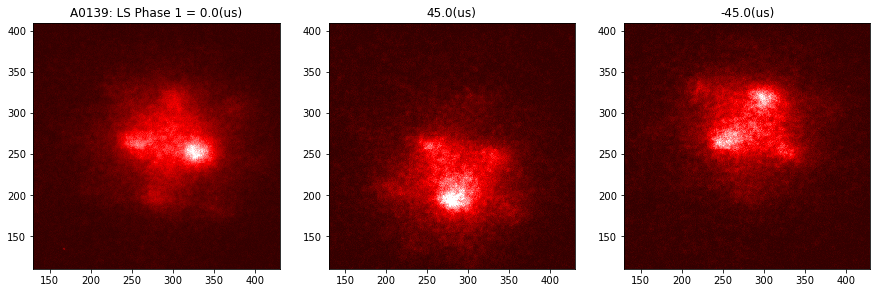

In [6]:
vmin = 0
vmax = 700
xlim_1 = 130
xlim_2 = 430
ylim_1 = 110
ylim_2 = 410

fig =plt.figure(figsize=[15,10])
ax1 = fig.add_subplot(2,3,1)
mappable =ax1.pcolormesh(img_trans_sample1, cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.set_title(param_name+ " = %.01f"%(sample1)+unit)

ax2 = fig.add_subplot(2,3,2)
mappable =ax2.pcolormesh(img_trans_sample2, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
ax2.set_aspect('equal')
ax2.set_xlim(xlim_1,xlim_2)
ax2.set_ylim(ylim_1,ylim_2)
ax2.set_title("%.01f"%(sample2)+unit)

ax3 = fig.add_subplot(2,3,3)
mappable =ax3.pcolormesh(img_trans_sample3, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
ax3.set_aspect('equal')
ax3.set_xlim(xlim_1,xlim_2)
ax3.set_ylim(ylim_1,ylim_2)
ax3.set_title("%.01f"%(sample3)+unit)

In [7]:
img_ave_by_unique_param = []
for i in range(len(unique_param)):
    img_temp = []
    for j in range(len(trans_files)):
        if scan_param[j] == unique_param[i]:
            img_temp.append(img_trans_list[j])
    img_ave_by_unique_param.append(np.average(img_temp, axis=0))

In [8]:
change = True
while change:
    change = False
    for i in range(len(unique_param)-1):
        if unique_param[i]>unique_param[i+1]:
            unique_param[i], unique_param[i+1] = unique_param[i+1], unique_param[i]
            img_ave_by_unique_param[i], img_ave_by_unique_param[i+1] = img_ave_by_unique_param[i+1], img_ave_by_unique_param[i]
            change = True

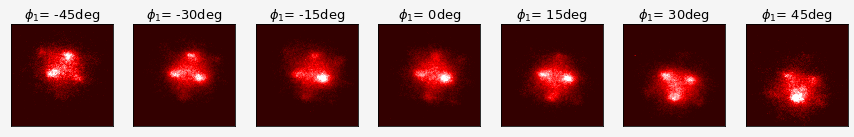

In [9]:
vmin = 50
vmax = 600

column_number = 7
row_number = 1


fig, axes = plt.subplots(row_number, column_number, figsize=(15,4), facecolor="whitesmoke")
plt.subplots_adjust(wspace=0.2, hspace=0.35)
for i in range(row_number):
    for j in range(column_number):
        if column_number*i+j< column_number*row_number:
            axes[j].pcolormesh(img_ave_by_unique_param[column_number*i+j], cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
            axes[j].set_aspect('equal')
            axes[j].set_xlim(xlim_1,xlim_2)
            axes[j].set_ylim(ylim_1,ylim_2)
            axes[j].xaxis.set_visible(False)
            axes[j].yaxis.set_visible(False)
            axes[j].set_title(r"$\phi_1$= %d"%(unique_param[column_number*i+j])+"deg", fontsize=13)


In [14]:
cx = 250
cy = 260
r = 12
momentum_peaks_C3_dx_list = [-35.646, 43.6125, -7.9659, 71.292, -87.225, 15.9318]
momentum_peaks_C3_dy_list = [29.7788, 15.980, -45.7598, -59.5576, -31.96,91.5196]
momentum_peaks_C2_dx_list = [35.6872832, -43.6125, 7.9659, -71.292, 87.225, -15.9318]
momentum_peaks_C2_dy_list = [-29.7788, -15.980, 45.7598, 59.5576, 31.96, -91.5196]
momentum_peaks_C1_dx_list = [0, 79.256753984491, -79.256753984491, 27.679518850925, -27.679518850925, -51.577235133566, 51.577235133566]
momentum_peaks_C1_dy_list = [0, -13.7973529288, 13.7973529288, -75.537038836463, 75.537038836463, -61.739685907663, 61.739685907663]

def calculateCentersOfSubROI(cx, cy, momentum_peaks_C1_dx_list, momentum_peaks_C1_dy_list, momentum_peaks_C2_dx_list, momentum_peaks_C2_dy_list, momentum_peaks_C3_dx_list, momentum_peaks_C3_dy_list):
    shift_dx_list = []
    shift_dy_list = []
    list(map(lambda x: shift_dx_list.extend(x), (momentum_peaks_C1_dx_list, momentum_peaks_C2_dx_list, momentum_peaks_C3_dx_list)))
    list(map(lambda x: shift_dy_list.extend(x), (momentum_peaks_C1_dy_list, momentum_peaks_C2_dy_list, momentum_peaks_C3_dy_list)))
    subROI_cx_list = cx+np.array(shift_dx_list)
    subROI_cy_list = cy+np.array(shift_dy_list)
    return subROI_cx_list, subROI_cy_list

subROI_cx_list, subROI_cy_list = calculateCentersOfSubROI(cx, cy, momentum_peaks_C1_dx_list, momentum_peaks_C1_dy_list, momentum_peaks_C2_dx_list, momentum_peaks_C2_dy_list, momentum_peaks_C3_dx_list, momentum_peaks_C3_dy_list)

def extractCircleROI(image, subROI_cx, subROI_cy, r):
    row, column = np.shape(image)
    ii, jj = np.meshgrid(np.arange(row), np.arange(column), indexing='ij')
    d2 = np.square(ii - subROI_cy) + np.square(jj - subROI_cx)
    extractedData = np.where(d2 < r * r, image, np.nan)
    return extractedData

def OpticalDensityInExtractedCircleROI(image, subROI_cx, subROI_cy, r):
    row, column = np.shape(image)
    ii, jj = np.meshgrid(np.arange(row), np.arange(column), indexing='ij')
    d2 = np.square(ii - subROI_cy) + np.square(jj - subROI_cx)
    extractedData = np.where(d2 < r * r, image, 0)
    normalizedOD = np.sum(extractedData)/np.sum(image)
    return normalizedOD

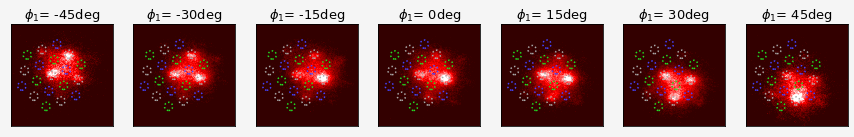

In [16]:


fig, axes = plt.subplots(row_number, column_number, figsize=(15,4), facecolor="whitesmoke")
plt.subplots_adjust(wspace=0.2, hspace=0.35)
for i in range(row_number):
    for j in range(column_number):
        if column_number*i+j< column_number*row_number:
            axes[j].pcolormesh(img_ave_by_unique_param[column_number*i+j], cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
            axes[j].set_aspect('equal')
            axes[j].set_xlim(xlim_1,xlim_2)
            axes[j].set_ylim(ylim_1,ylim_2)
            axes[j].xaxis.set_visible(False)
            axes[j].yaxis.set_visible(False)
            axes[j].set_title(r"$\phi_1$= %d"%(unique_param[column_number*i+j])+"deg", fontsize=13)
            for k in range(len(subROI_cx_list)):
                if k < len(momentum_peaks_C1_dx_list):
                    color = '#aaaaaa'
                elif len(momentum_peaks_C1_dx_list)<=k<len(momentum_peaks_C1_dx_list)+len(momentum_peaks_C2_dx_list):
                    color = '#22dd22'
                else:
                    color = '#4444ff'
                region = CirclePixelRegion(center=PixCoord(x=subROI_cx_list[k], y=subROI_cy_list[k]), radius=r)
                region.plot(ax=axes[j], color=color, lw=1.5, linestyle = ':')